# Exploring automatic detection of trends

Paleoclimate datasets will generally contain the following trends:
* Linear (increasing or decreasing)
* Non-linear, monotically increasing or decreasing
* Sine wave (longer periodicity signals)
* S-shaped (deglaciation type event)

We will use the [Mann-Kendall trend test](https://www.statisticshowto.com/mann-kendall-trend-test/) with this [Python implementation](https://pypi.org/project/pymannkendall/). We will test the modifications by Hamed and Rao (1998)  and Yue, S., & Wang, C. Y. (2004) that take autocorrelation into account. 

This notebook uses version 0.8.2 of [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/). 

## Creating trends in pseudo-records

In [1]:
import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import pymannkendall as mk
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from scipy.optimize import curve_fit
from kneed import KneeLocator
from sklearn.metrics import r2_score

/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


ImportError: cannot import name '_centered' from 'scipy.signal.signaltools' (/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/scipy/signal/signaltools.py)

In [2]:
def add_trend(time, value, trend_type='linear'):
    
    if trend_type=='linear':
        
        slope = 0.01
        intercept = -1
        ys = time*slope+intercept
    
    elif trend_type=='polynomial':
        slope = 1e-5
        intercept = -1
        ys = slope*time**2+intercept
    
    elif trend_type=='sinusoidal':
        freqs=1/1500
        ys= 2*np.std(value)*np.cos(2*np.pi*freqs*time)
        
    elif trend_type =='s-shape':
        cut=[666,1332]
        value_offset_1 = np.mean(value[:cut[0]])+8
        value_offset_2 = np.mean(value[cut[1]:])
        slope = (value_offset_2-value_offset_1)/(time[cut[1]]-time[cut[0]])
        intercept = value_offset_2-(slope*time[cut[1]])
        
        ys=np.zeros(len(time))
        ys[0:cut[0]] = value_offset_1
        ys[cut[0]:cut[1]] = time[cut[0]:cut[1]]*slope+intercept
        ys[cut[1]:] = value_offset_2
        
    return ys

def create_signal(trend_type='linear'):
    freqs=[1/20,1/80]
    time=np.arange(2001)
    signals=[]
    for freq in freqs:
        signals.append(np.cos(2*np.pi*freq*time))
    signal=sum(signals)

    # Add colored noise

    t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)
    noisy_sig = signal + (v-np.mean(v))/np.std(v)
    
    ### add trend
    if trend_type is None:
        signal_trend = noisy_sig
    else:
        signal_trend = noisy_sig+add_trend(time,noisy_sig,trend_type=trend_type)
    
    return time,signal_trend

### No trend

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

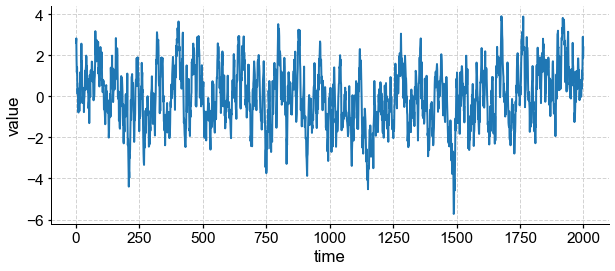

In [3]:
time,value = create_signal(trend_type=None)
ts_none = pyleo.Series(time=time,value=value)
ts_none.plot()

#### MK Test

In [4]:
result_none = mk.hamed_rao_modification_test(ts_none.value, lag=1)
result_none

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.664094861298083, z=0.4342665913095893, Tau=0.010731634182908546, s=21474.0, var_s=2444964786.414379, slope=4.226419683308713e-05, intercept=-0.047994449105709824)

In [5]:
result_yue_linear = mk.yue_wang_modification_test(ts_none.value, lag=1)
result_yue_linear

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='no trend', h=False, p=0.6651529979339785, z=0.4328097384038063, Tau=0.010731634182908546, s=21474.0, var_s=2461452164.44114, slope=4.226419683308713e-05, intercept=-0.047994449105709824)

#### Linear regression

In [6]:
reg_res_none = stats.linregress(ts_none.time,ts_none.value)
reg_res_none

LinregressResult(slope=5.004903937360934e-05, intercept=-0.04904953912373431, rvalue=0.01983982358307916, pvalue=0.37506898788318965, stderr=5.6411292838562704e-05, intercept_stderr=0.06514629197130618)

#### Fitting various model and use the RMSE as a criteria

The idea is to fit various polynomial and see if the RMSE decreases "significantly". The no trend can be determined by calculating goodness of fit with a straight line through the mean.

In [ ]:
def calculate_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calculate_r2(predictions, targets):
    return r2_score(targets,predictions)

def poly1(x,a,b):
    return a*x+b

def poly2(x,a,b,c):
    return a*x**2+b*x+c

def poly3(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

def poly4(x,a,b,c,d,e):
    return a*x**4+b*x**3+c*x**2+d*x+e

def poly5(x,a,b,c,d,e,f):
    return a*x**5+b*x**4+c*x**3+d*x**2+e*x+f

def poly6(x,a,b,c,d,e,f,g):
    return a*x**6+b*x**5+c*x**4+d*x**3+e*x**2+f*x+g

def poly7(x,a,b,c,d,e,f,g,h):
    return a*x**7+b*x**6+c*x**5+d*x**4+e*x**3+f*x**2+g*x+h

def fit_good(time,value):

    rmse = []
    r_squared=[]
    funcs = ['poly0','poly1','poly2','poly3','poly4','poly5','poly6','poly7']

    for func in funcs:
        if func == 'poly0':
            preds = np.full(np.shape(time),np.mean(value))
        elif func == 'poly1':
            params,covs = curve_fit(poly1,time,value)
            preds = poly1(time,*params)
        elif func == 'poly2':
            params,covs = curve_fit(poly2,time,value)
            preds = poly2(time,*params)
        elif func == 'poly3':
            params,covs = curve_fit(poly3,time,value)
            preds = poly3(time,*params)
        elif func == 'poly4':
            params,covs = curve_fit(poly4,time,value)
            preds = poly4(time,*params)
        elif func == 'poly5':
            params,covs = curve_fit(poly5,time,value)
            preds = poly5(time,*params)
        elif func == 'poly6':
            params,covs = curve_fit(poly6,time,value)
            preds = poly6(time,*params)
        elif func == 'poly7':
            params,covs = curve_fit(poly7,time,value)
            preds = poly7(time,*params)
        rmse.append(calculate_rmse(preds,value))
        r_squared.append(calculate_r2(preds,value))
    res = pd.DataFrame({'Fit':funcs,'RMSE':rmse,'R2':r_squared})
    return res

In [91]:
rmse_none = fit_good(ts_none.time,ts_none.value)
rmse_none

,Fit,RMSE,R2
0,poly0,1.457184,0.000000
1,poly1,1.456897,0.000394
2,poly2,1.408286,0.065987
3,poly3,1.390173,0.089859
4,poly4,1.388303,0.092305
5,poly5,1.373062,0.112125
6,poly6,1.371535,0.114099
7,poly7,1.370767,0.115091


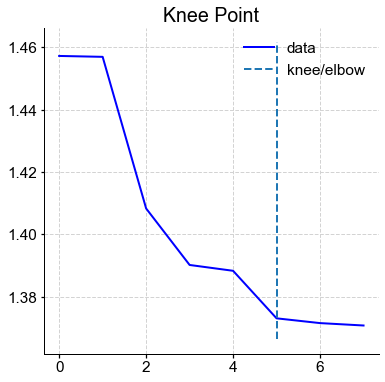

In [62]:
kneedle_none = KneeLocator(np.arange(0,len(rmse_none['RMSE']),1), rmse_none['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_none.plot_knee()

In [63]:
print(round(kneedle_none.knee, 1))

5


Filter first:

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

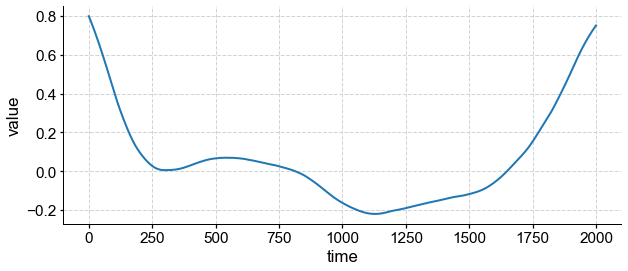

In [151]:
ts_none_filt = ts_none.filter(cutoff_scale = np.ptp(ts_none.time), method = 'lanczos')
ts_none_filt.plot()

In [152]:
rmse_none_filt = fit_good(ts_none_filt.time,ts_none_filt.value)
rmse_none_filt

,Fit,RMSE,R2
0,poly0,0.242773,0.000000
1,poly1,0.242623,0.001239
2,poly2,0.114206,0.778704
3,poly3,0.100970,0.827026
4,poly4,0.066766,0.924368
5,poly5,0.039742,0.973202
6,poly6,0.024590,0.989741
7,poly7,0.024553,0.989772


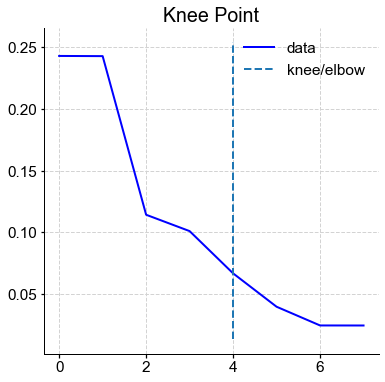

In [153]:
kneedle_none_filt = KneeLocator(np.arange(0,len(rmse_none_filt['RMSE']),1), rmse_none_filt['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_none_filt.plot_knee()

### Linear trend

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

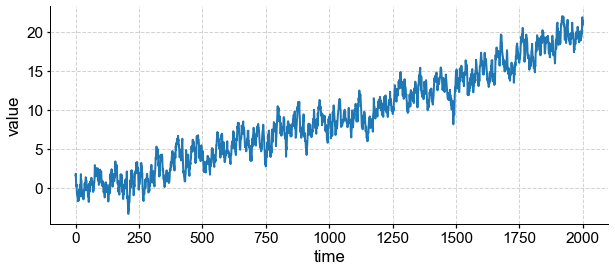

In [7]:
time,value = create_signal(trend_type='linear')
ts_linear = pyleo.Series(time=time,value=value)
ts_linear.plot()

#### MK Test

In [8]:
result_hamed_linear = mk.hamed_rao_modification_test(ts_linear.value, lag=1)
result_hamed_linear

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0, z=34.447292844232976, Tau=0.8512253873063468, s=1703302.0, var_s=2444964786.414379, slope=0.010042264196833087, intercept=-1.5461752787505567)

In [9]:
result_yue_linear = mk.yue_wang_modification_test(ts_linear.value, lag=1)
result_yue_linear

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='increasing', h=True, p=0.0, z=34.33173102188524, Tau=0.8512253873063468, s=1703302.0, var_s=2461452164.44114, slope=0.010042264196833087, intercept=-1.5461752787505567)

#### Linear regression

In [10]:
reg_res_linear = stats.linregress(ts_linear.time,ts_linear.value)
reg_res_linear

LinregressResult(slope=0.010050049039373612, intercept=-1.049049539123736, rvalue=0.9699230471309813, pvalue=0.0, stderr=5.641129283856249e-05, intercept_stderr=0.06514629197130593)

#### Fitting various models

In [92]:
rmse_linear = fit_good(ts_linear.time,ts_linear.value)
rmse_linear

,Fit,RMSE,R2
0,poly0,5.985319,0.000000
1,poly1,1.456897,0.940751
2,poly2,1.408286,0.944639
3,poly3,1.390173,0.946054
4,poly4,1.388303,0.946199
5,poly5,1.373062,0.947373
6,poly6,1.371535,0.947490
7,poly7,1.370767,0.947549


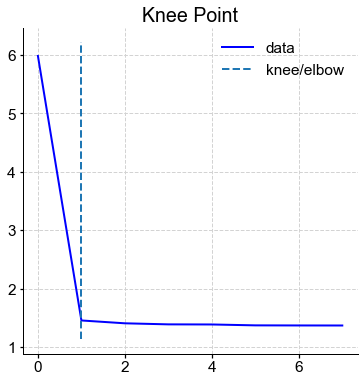

In [64]:
kneedle_linear = KneeLocator(np.arange(0,len(rmse_linear['RMSE']),1), rmse_linear['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_linear.plot_knee()

In [65]:
print(round(kneedle_linear.knee, 1))

1


Try to filter first

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

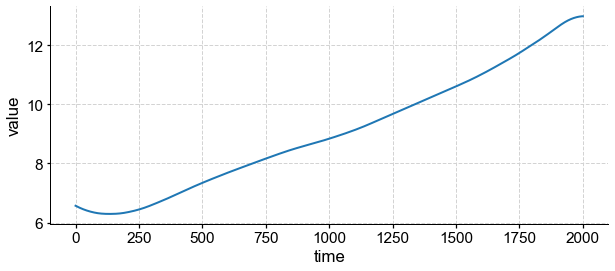

In [154]:
ts_linear_filt = ts_linear.filter(cutoff_scale = np.ptp(ts_linear.time), method = 'lanczos')
ts_linear_filt.plot()

In [155]:
rmse_linear_filt = fit_good(ts_linear_filt.time,ts_linear_filt.value)
rmse_linear_filt

,Fit,RMSE,R2
0,poly0,1.986664,0.000000
1,poly1,0.243978,0.984918
2,poly2,0.117057,0.996528
3,poly3,0.110910,0.996883
4,poly4,0.081017,0.998337
5,poly5,0.041640,0.999561
6,poly6,0.027551,0.999808
7,poly7,0.024976,0.999842


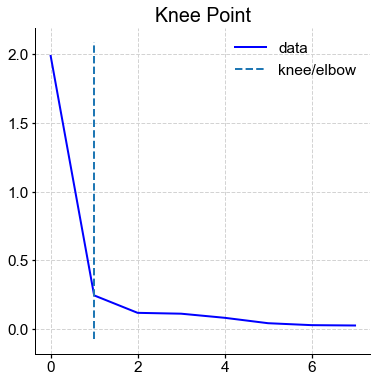

In [156]:
kneedle_linear_filt = KneeLocator(np.arange(0,len(rmse_linear_filt['RMSE']),1), rmse_linear_filt['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_linear_filt.plot_knee()

In [135]:
print(round(kneedle_linear_filt.knee, 1))

1


### Polynomial

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

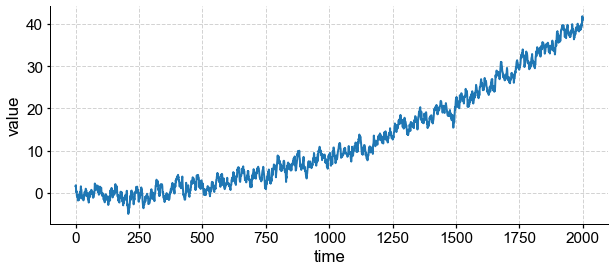

In [11]:
time,value = create_signal(trend_type='polynomial')
ts_poly = pyleo.Series(time=time,value=value)
ts_poly.plot()

#### MK Test

In [12]:
result_hamed_poly = mk.hamed_rao_modification_test(ts_poly.value, lag=1)
result_hamed_poly

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0, z=34.725688091953906, Tau=0.8892693653173414, s=1779428.0, var_s=2625781788.5251017, slope=0.019717309601857826, intercept=-11.040038994535024)

In [13]:
result_yue_poly = mk.yue_wang_modification_test(ts_poly.value, lag=1)
result_yue_poly

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='increasing', h=True, p=0.0, z=34.67824109299613, Tau=0.8892693653173414, s=1779428.0, var_s=2632971928.000662, slope=0.019717309601857826, intercept=-11.040038994535024)

#### Linear Regression

In [14]:
reg_res_poly = stats.linregress(ts_poly.time,ts_poly.value)
reg_res_poly

LinregressResult(slope=0.020050049039373612, intercept=-7.712382872457068, rvalue=0.953969493634601, pvalue=0.0, stderr=0.00014097961523113278, intercept_stderr=0.16280958499095777)

#### Fitting various models

In [93]:
rmse_poly = fit_good(ts_poly.time,ts_poly.value)
rmse_poly

,Fit,RMSE,R2
0,poly0,12.140522,0.000000
1,poly1,3.640987,0.910058
2,poly2,1.408286,0.986544
3,poly3,1.390173,0.986888
4,poly4,1.388303,0.986923
5,poly5,1.373062,0.987209
6,poly6,1.371535,0.987237
7,poly7,1.370767,0.987252


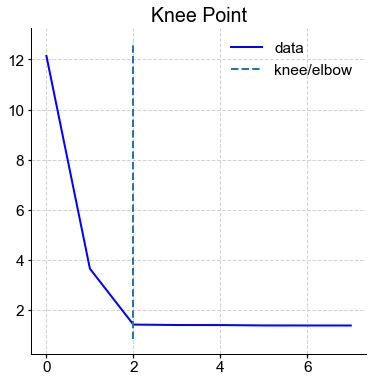

In [60]:
kneedle_poly = KneeLocator(np.arange(0,len(rmse_poly['RMSE']),1), rmse_poly['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_poly.plot_knee()

In [61]:
print(round(kneedle_poly.knee, 1))

2


Filter the trend out:

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

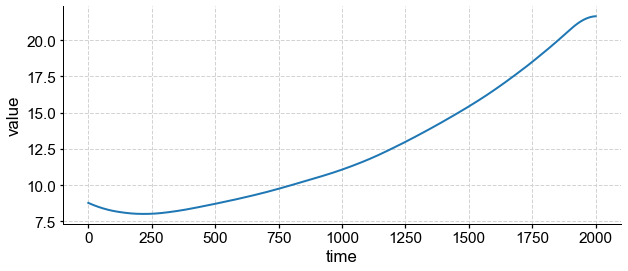

In [157]:
ts_poly_filt = ts_poly.filter(cutoff_scale = np.ptp(ts_poly.time), method = 'lanczos')
ts_poly_filt.plot()

In [158]:
rmse_poly_filt = fit_good(ts_poly_filt.time,ts_poly_filt.value)
rmse_poly_filt

,Fit,RMSE,R2
0,poly0,4.138830,0.000000
1,poly1,1.230125,0.911663
2,poly2,0.115048,0.999227
3,poly3,0.113021,0.999254
4,poly4,0.098124,0.999438
5,poly5,0.048420,0.999863
6,poly6,0.046062,0.999876
7,poly7,0.038941,0.999911


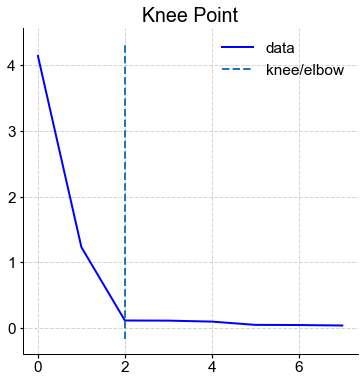

In [159]:
kneedle_poly_filt = KneeLocator(np.arange(0,len(rmse_poly_filt['RMSE']),1), rmse_poly_filt['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_poly_filt.plot_knee()

In [111]:
print(round(kneedle_poly_filt.knee, 1))

2


### Sinusoidal

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

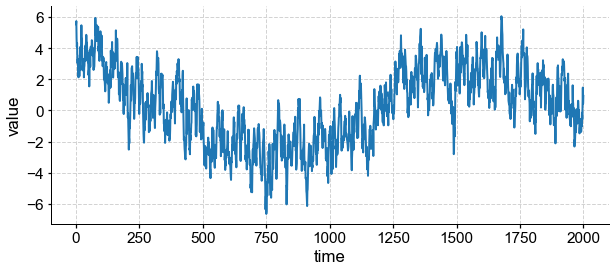

In [15]:
time,value = create_signal(trend_type='sinusoidal')
ts_sin = pyleo.Series(time=time,value=value)
ts_sin.plot()

#### MK Test

In [16]:
result_hamed_sin = mk.hamed_rao_modification_test(ts_sin.value, lag=1)
result_hamed_sin

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0003152205736742797, z=3.6024594589038066, Tau=0.09166716641679161, s=183426.0, var_s=2592500514.9774027, slope=0.0006622246166730092, intercept=-0.2705976633862921)

In [17]:
result_yue_sin = mk.yue_wang_modification_test(ts_sin.value, lag=1)
result_yue_sin

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='increasing', h=True, p=0.00031346043144675484, z=3.603914315747038, Tau=0.09166716641679161, s=183426.0, var_s=2590407814.937109, slope=0.0006622246166730092, intercept=-0.2705976633862921)

Plot the trend line on top of the sinusoidal curve:

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

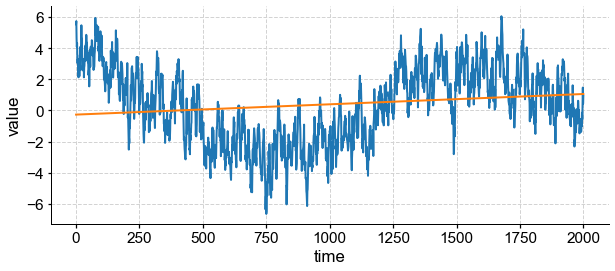

In [19]:
value_trend = result_yue_sin.slope*ts_sin.time+result_yue_sin.intercept
ts_trend_sin=pyleo.Series(time=time,value=value_trend)
ms_sin=pyleo.MultipleSeries([ts_sin,ts_trend_sin])
ms_sin.plot()

The trend detection was a lucky accident and won't work if the beginning/end of the series have closer values. Also might be too sensitive to small changes.

#### Linear Regression

In [20]:
reg_res_sin = stats.linregress(ts_sin.time,ts_sin.value)
reg_res_sin

LinregressResult(slope=0.0005760673842014522, intercept=-0.2735844327811698, rvalue=0.13917544837553927, pvalue=4.046299877006582e-10, stderr=9.167626083366812e-05, intercept_stderr=0.10587185924278375)

#### Fitting various models

In [94]:
rmse_sin = fit_good(ts_sin.time,ts_sin.value)
rmse_sin

,Fit,RMSE,R2
0,poly0,2.390931,0.000000
1,poly1,2.367662,0.019370
2,poly2,2.035444,0.275257
3,poly3,1.518511,0.596632
4,poly4,1.421424,0.646562
5,poly5,1.387911,0.663032
6,poly6,1.376256,0.668667
7,poly7,1.371833,0.670793


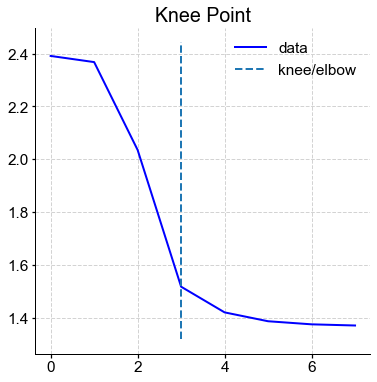

In [66]:
kneedle_sin = KneeLocator(np.arange(0,len(rmse_sin['RMSE']),1), rmse_sin['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_sin.plot_knee()

In [67]:
print(round(kneedle_sin.knee, 1))

3


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

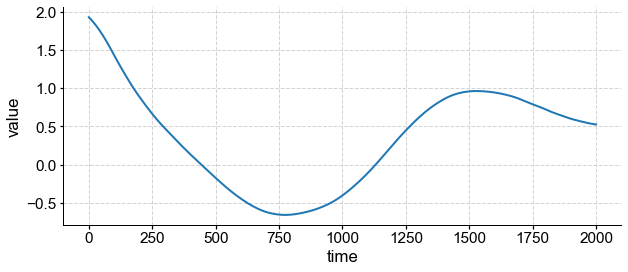

In [162]:
ts_sin_filter = ts_sin.filter(cutoff_scale = np.ptp(ts_sin.time), method = 'lanczos')
ts_sin_filter.plot()

In [163]:
rmse_sin_filt = fit_good(ts_sin_filter.time,ts_sin_filter.value)
rmse_sin_filt

,Fit,RMSE,R2
0,poly0,0.661524,0.000000
1,poly1,0.656933,0.013831
2,poly2,0.458564,0.519483
3,poly3,0.161260,0.940576
4,poly4,0.123652,0.965061
5,poly5,0.075658,0.986920
6,poly6,0.032472,0.997591
7,poly7,0.026945,0.998341


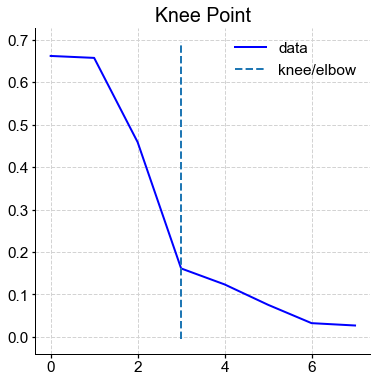

In [164]:
kneedle_sin_filt = KneeLocator(np.arange(0,len(rmse_sin_filt['RMSE']),1), rmse_sin_filt['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_sin_filt.plot_knee()

In [115]:
print(round(kneedle_sin_filt.knee, 1))

3


In [166]:
ts_sin_detrend = ts_sin.detrend()
rmse_sin_detrend = fit_good(ts_sin_detrend.time,ts_sin_detrend.value)
rmse_sin_detrend

,Fit,RMSE,R2
0,poly0,1.404909,0.000000
1,poly1,1.401556,0.004767
2,poly2,1.395378,0.013521
3,poly3,1.373266,0.044538
4,poly4,1.370028,0.049039
5,poly5,1.360381,0.062384
6,poly6,1.360381,0.062385
7,poly7,1.358909,0.064412


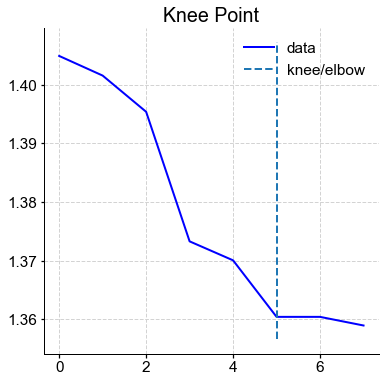

In [167]:
kneedle_sin_detrend = KneeLocator(np.arange(0,len(rmse_sin_detrend['RMSE']),1), rmse_sin_detrend['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_sin_detrend.plot_knee()

### S-Shaped curve

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

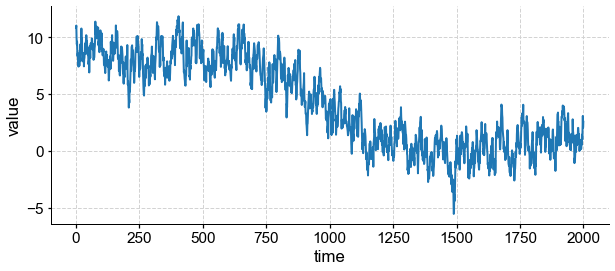

In [21]:
time,value = create_signal(trend_type='s-shape')
ts_sshape = pyleo.Series(time=time,value=value)
ts_sshape.plot()

#### MK Test

In [22]:
result_hamed_sshape = mk.hamed_rao_modification_test(ts_sshape.value, lag=1)
result_hamed_sshape

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=0.0, z=-24.124386365897614, Tau=-0.609568215892054, s=-1219746.0, var_s=2556380772.4048624, slope=-0.005729005747815254, intercept=9.50499408037862)

In [23]:
result_yue_sshape = mk.yue_wang_modification_test(ts_sshape.value, lag=1)
result_yue_sshape

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='decreasing', h=True, p=0.0, z=-24.101485273917394, Tau=-0.609568215892054, s=-1219746.0, var_s=2561241196.9457254, slope=-0.005729005747815254, intercept=9.50499408037862)

#### Linear Regression

In [24]:
reg_res_sshape = stats.linregress(ts_sshape.time,ts_sshape.value)
reg_res_sshape

LinregressResult(slope=-0.005750998257419235, intercept=9.934366024394693, rvalue=-0.8550292589530324, pvalue=0.0, stderr=7.801379844355738e-05, intercept_stderr=0.09009383468198692)

#### Fitting various models

In [95]:
rmse_sshape = fit_good(ts_sshape.time,ts_sshape.value)
rmse_sshape

,Fit,RMSE,R2
0,poly0,3.885247,0.000000
1,poly1,2.014811,0.731075
2,poly2,1.979188,0.740500
3,poly3,1.513139,0.848323
4,poly4,1.511561,0.848639
5,poly5,1.367125,0.876183
6,poly6,1.365511,0.876476
7,poly7,1.361807,0.877145


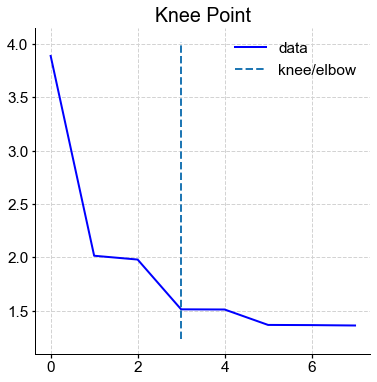

In [68]:
kneedle_sshape = KneeLocator(np.arange(0,len(rmse_sshape['RMSE']),1), rmse_sshape['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_sshape.plot_knee()

In [69]:
print(round(kneedle_sshape.knee, 1))

3


Try filtering first

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

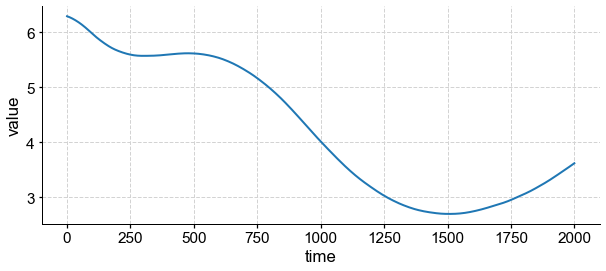

In [176]:
ts_sshape_filter = ts_sshape.filter(cutoff_scale = np.ptp(ts_sshape.time), method = 'lanczos')
ts_sshape_filter.plot()

In [177]:
rmse_sshape_filt = fit_good(ts_sshape_filter.time,ts_sshape_filter.value)
rmse_sshape_filt

,Fit,RMSE,R2
0,poly0,1.240744,0.000000
1,poly1,0.484375,0.847595
2,poly2,0.433862,0.877725
3,poly3,0.193008,0.975802
4,poly4,0.177893,0.979443
5,poly5,0.055642,0.997989
6,poly6,0.045784,0.998638
7,poly7,0.022913,0.999659


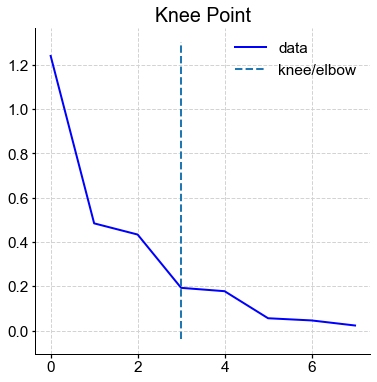

In [178]:
kneedle_sshape_filt = KneeLocator(np.arange(0,len(rmse_sshape_filt['RMSE']),1), rmse_sshape_filt['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_sshape_filt.plot_knee()

## ID Trends in real records

We will consider three series:

* MD98-2181 SST over the Holocene from Khider et al. (low signal-to-noise ratio, cooling trend)
* Deglacial Greenland d18O record, which contains a significant trend and the BA/YD event
* The LR04 record, cooling trend

### MD98-2181

In [25]:
D=pyleo.Lipd('../Outlier/MD982181.Khider.2014.lpd')

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: MD982181.Khider.2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Finished read: 1 record


In [26]:
ts_MD81=D.to_LipdSeries(number=14)

extracting paleoData...
extracting: MD982181.Khider.2014
Created time series: 31 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [cal yr BP]', ylabel='sst [degrees Celcius]'>)

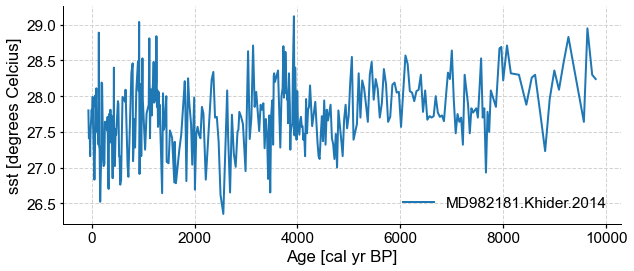

In [27]:
ts_MD81.plot()

In [28]:
result_hamed_MD81 = mk.hamed_rao_modification_test(ts_MD81.value, lag=1)
result_hamed_MD81

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=5.873720085869394e-07, z=4.995323570929301, Tau=0.22389430549667938, s=12676.0, var_s=6438262.599422171, slope=0.001682242990654203, intercept=27.437383177570094)

In [29]:
result_yue_MD81 = mk.yue_wang_modification_test(ts_MD81.value, lag=1)
result_yue_MD81

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='increasing', h=True, p=3.50853971209375e-07, z=5.093855633797625, Tau=0.22389430549667938, s=12676.0, var_s=6191596.859658254, slope=0.001682242990654203, intercept=27.437383177570094)

In [184]:
rmse_MD81 = fit_good(ts_MD81.time,ts_MD81.value)
rmse_MD81

,Fit,RMSE,R2
0,poly0,0.492832,0.000000
1,poly1,0.462876,0.117872
2,poly2,0.462034,0.121079
3,poly3,0.461676,0.122441
4,poly4,0.461676,0.122441
5,poly5,0.460307,0.127637
6,poly6,0.459979,0.128879
7,poly7,0.459520,0.130620


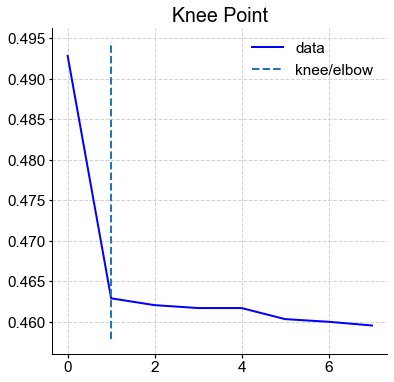

In [71]:
kneedle_MD81 = KneeLocator(np.arange(0,len(rmse_MD81['RMSE']),1), rmse_MD81['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_MD81.plot_knee()

In [72]:
print(round(kneedle_MD81.knee, 1))

1


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [cal yr BP]', ylabel='sst [degrees Celcius]'>)

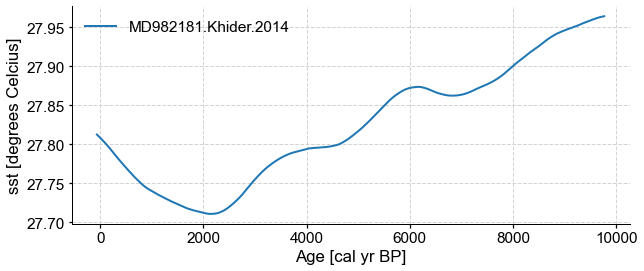

In [181]:
ts_MD81_filter = ts_MD81.interp().filter(cutoff_scale = np.ptp(ts_MD81.time), method = 'lanczos')
ts_MD81_filter.plot()

In [183]:
rmse_MD81_filt = fit_good(ts_MD81_filter.time,ts_MD81_filter.value)
rmse_MD81_filt

,Fit,RMSE,R2
0,poly0,0.075286,0.000000
1,poly1,0.028928,0.852359
2,poly2,0.022989,0.906756
3,poly3,0.017352,0.946879
4,poly4,0.009838,0.982924
5,poly5,0.009554,0.983896
6,poly6,0.008327,0.987766
7,poly7,0.008315,0.987803


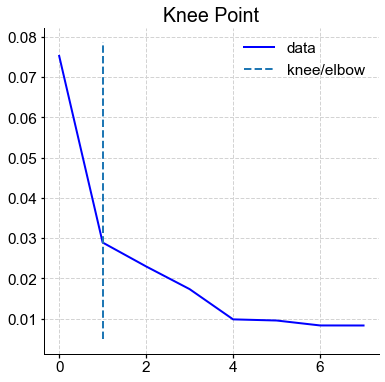

In [186]:
kneedle_MD81_filt = KneeLocator(np.arange(0,len(rmse_MD81_filt['RMSE']),1), rmse_MD81_filt['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_MD81_filt.plot_knee()

<AxesSubplot:xlabel='Age [cal yr BP]', ylabel='sst [degrees Celcius]'>

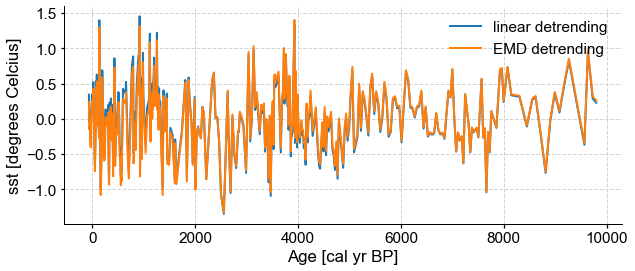

In [206]:
fig,ax = ts_MD81.detrend(method='linear').plot(label='linear detrending')
ts_MD81.detrend().plot(ax=ax,label='EMD detrending')

### Greenland d18O

In [30]:
df = pd.read_csv('../Outlier/GISP2_Deglacial.csv')
df

,Age [yr BP],d18O [per mil]
0,10014.2,-34.59
1,10038.0,-35.45
2,10061.5,-35.61
3,10084.5,-35.57
4,10109.4,-34.65
...,...,...
209,23303.0,-38.31
210,23406.0,-40.08
211,23528.0,-41.58
212,23656.0,-41.91


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [yr BP]', ylabel='d18O [per mil]'>)

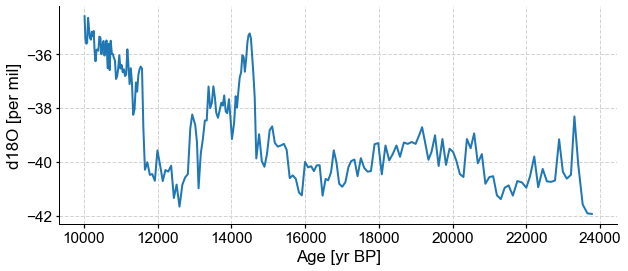

In [31]:
ts_GISP=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='d18O',
                time_unit='yr BP', value_unit='per mil')
ts_GISP.plot()

In [32]:
result_hamed_GISP = mk.hamed_rao_modification_test(ts_GISP.value, lag=1)
result_hamed_GISP

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=5.635492072997295e-13, z=-7.209020076913433, Tau=-0.524417533236804, s=-11952.0, var_s=2748248.646480541, slope=-0.024999999999999974, intercept=-36.5475)

In [33]:
result_yue_GISP = mk.yue_wang_modification_test(ts_GISP.value, lag=1)
result_yue_GISP

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='decreasing', h=True, p=4.738875958310018e-12, z=-6.91318365003117, Tau=-0.524417533236804, s=-11952.0, var_s=2988493.42374447, slope=-0.024999999999999974, intercept=-36.5475)

In [97]:
rmse_GISP = fit_good(ts_GISP.time,ts_GISP.value)
rmse_GISP

,Fit,RMSE,R2
0,poly0,1.947867,0.000000
1,poly1,1.395764,0.486541
2,poly2,1.303345,0.552286
3,poly3,1.263921,0.578962
4,poly4,1.240841,0.594198
5,poly5,1.193216,0.624751
6,poly6,1.179158,0.633541
7,poly7,1.153106,0.649555


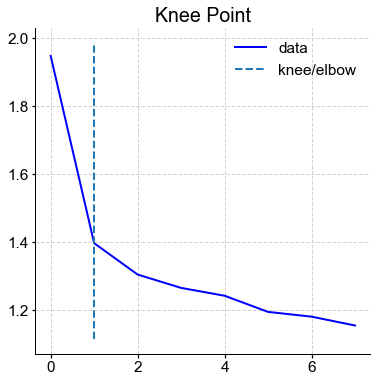

In [74]:
kneedle_GISP = KneeLocator(np.arange(0,len(rmse_GISP['RMSE']),1), rmse_GISP['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_GISP.plot_knee()

In [75]:
print(round(kneedle_GISP.knee, 1))

1


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [yr BP]', ylabel='d18O [per mil]'>)

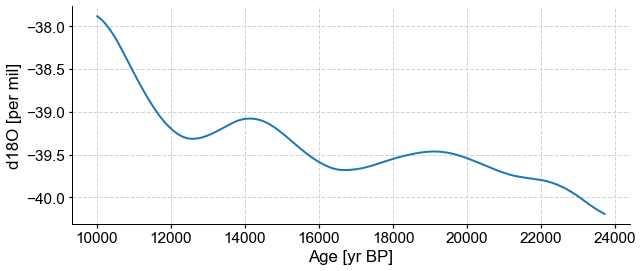

In [190]:
ts_GISP_filter = ts_GISP.interp().filter(cutoff_scale = np.ptp(ts_GISP.time), method = 'lanczos')
ts_GISP_filter.plot()

In [192]:
rmse_GISP_filt = fit_good(ts_GISP_filter.time,ts_GISP_filter.value)
rmse_GISP_filt

,Fit,RMSE,R2
0,poly0,0.464775,0.000000
1,poly1,0.238532,0.736606
2,poly2,0.209189,0.797422
3,poly3,0.140036,0.909219
4,poly4,0.135418,0.915108
5,poly5,0.120254,0.933056
6,poly6,0.103320,0.950582
7,poly7,0.102429,0.951431


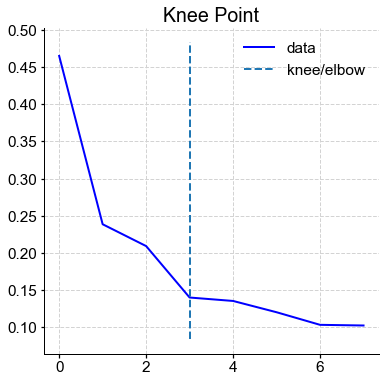

In [193]:
kneedle_GISP_filt = KneeLocator(np.arange(0,len(rmse_GISP_filt['RMSE']),1), rmse_GISP_filt['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_GISP_filt.plot_knee()

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [yr BP]', ylabel='d18O [per mil]'>)

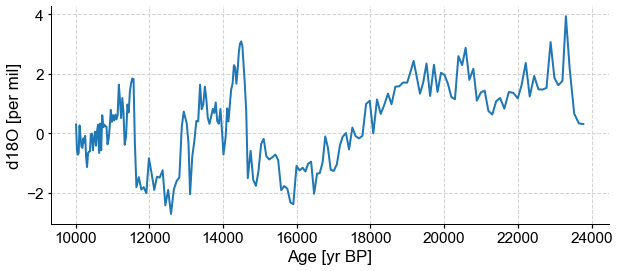

In [198]:
ts_GISP.detrend().plot()

<AxesSubplot:xlabel='Age [yr BP]', ylabel='d18O [per mil]'>

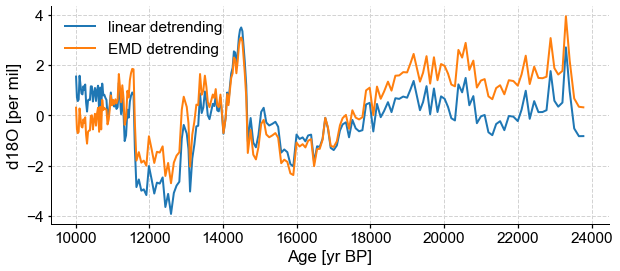

In [207]:
fig,ax = ts_GISP.detrend(method='linear').plot(label='linear detrending')
ts_GISP.detrend().plot(ax=ax,label='EMD detrending')

### LR04

In [34]:
df = pd.read_csv('../Outlier/LR04.csv',skiprows=4)
df

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03
...,...,...,...
2110,5300.0,2.91,0.06
2111,5305.0,2.79,0.04
2112,5310.0,2.79,0.09
2113,5315.0,2.84,0.07


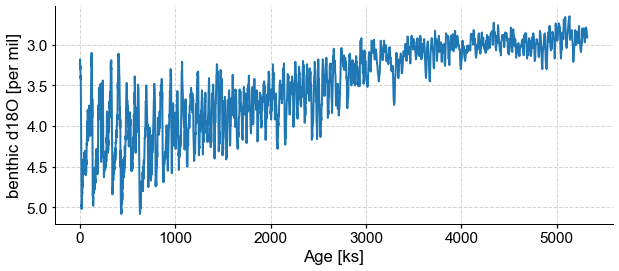

In [35]:
ts_LR04=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='benthic d18O',
                time_unit='ks', value_unit='per mil')

fig,ax = ts_LR04.plot()
ax.invert_yaxis()

In [36]:
result_hamed_LR04 = mk.hamed_rao_modification_test(ts_LR04.value, lag=1)
result_hamed_LR04

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=0.0, z=-24.88993327365514, Tau=-0.6038674959909285, s=-1349979.0, var_s=2941751051.999399, slope=-0.0007506053268765135, intercept=4.493389830508475)

In [37]:
result_yue_LR04 = mk.yue_wang_modification_test(ts_LR04.value, lag=1)
result_yue_LR04

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='decreasing', h=True, p=0.0, z=-24.59706673781309, Tau=-0.6038674959909285, s=-1349979.0, var_s=3012220384.1440706, slope=-0.0007506053268765135, intercept=4.493389830508475)

In [98]:
rmse_LR04 = fit_good(ts_LR04.time,ts_LR04.value)
rmse_LR04

,Fit,RMSE,R2
0,poly0,0.541362,0.000000
1,poly1,0.327218,0.634658
2,poly2,0.326658,0.635909
3,poly3,0.321681,0.646918
4,poly4,0.321664,0.646956
5,poly5,0.321564,0.647176
6,poly6,0.321070,0.648258
7,poly7,0.321044,0.648316


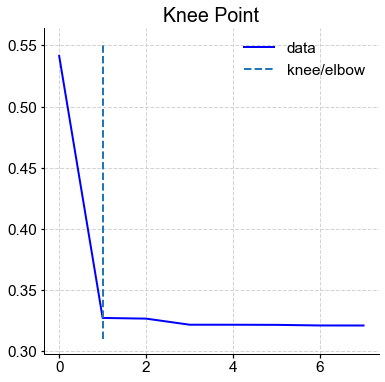

In [77]:
kneedle_LR04 = KneeLocator(np.arange(0,len(rmse_LR04['RMSE']),1), rmse_LR04['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_LR04.plot_knee()

In [78]:
print(round(kneedle_LR04.knee, 1))

1


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [ks]', ylabel='benthic d18O [per mil]'>)

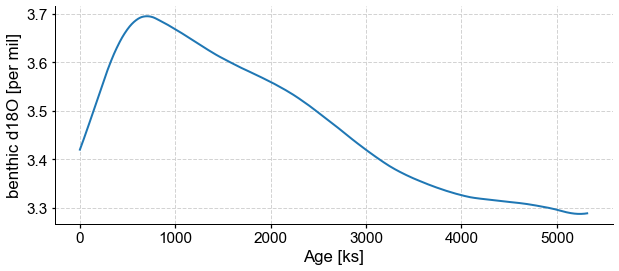

In [199]:
ts_LR04_filter = ts_LR04.interp().filter(cutoff_scale = np.ptp(ts_LR04.time), method = 'lanczos')
ts_LR04_filter.plot()

In [203]:
rmse_LR04_filt = fit_good(ts_LR04_filter.time,ts_LR04_filter.value)
rmse_LR04_filt

,Fit,RMSE,R2
0,poly0,0.137294,0.000000
1,poly1,0.055464,0.836801
2,poly2,0.053754,0.846708
3,poly3,0.028673,0.956384
4,poly4,0.016719,0.985171
5,poly5,0.013437,0.990421
6,poly6,0.007681,0.996870
7,poly7,0.006355,0.997858


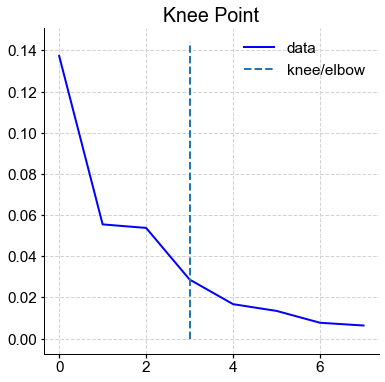

In [204]:
kneedle_LR04_filt = KneeLocator(np.arange(0,len(rmse_LR04_filt['RMSE']),1), rmse_LR04_filt['RMSE'], S=1.0, curve="convex", direction="decreasing")
kneedle_LR04_filt.plot_knee()

<AxesSubplot:xlabel='Age [ks]', ylabel='benthic d18O [per mil]'>

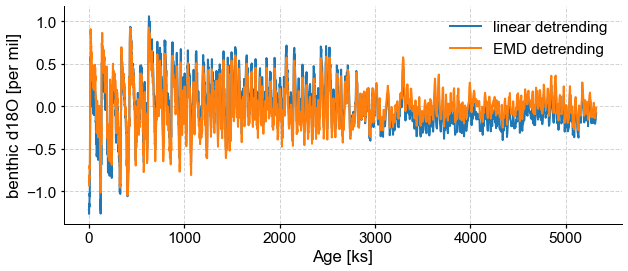

In [208]:
fig,ax = ts_LR04.detrend(method='linear').plot(label='linear detrending')
ts_LR04.detrend().plot(ax=ax,label='EMD detrending')

### Nino 3 record

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Year [CE]', ylabel='Niño 3 [$^{\\circ}$C]'>)

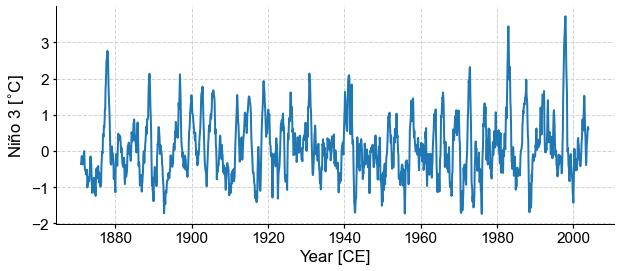

In [211]:
df = pd.read_csv('wtc_test_data_nino_even.csv')

ts_nino = pyleo.Series(time =  df['t'], value = df['nino'],
                  time_name = 'Year', value_name = 'Niño 3',
                  time_unit = 'CE', value_unit = '$^{\circ}$C')

ts_nino.plot()

In [213]:
result_hamed_nino = mk.hamed_rao_modification_test(ts_nino.value, lag=1)
result_hamed_nino

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.10235136087665841, z=1.6335595797801938, Tau=0.04611528822055138, s=58696.0, var_s=1291017877.4236267, slope=0.00011548216763739052, intercept=-0.11443036269081894)

In [214]:
result_yue_nino = mk.yue_wang_modification_test(ts_nino.value, lag=1)
result_yue_nino

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='no trend', h=False, p=0.10405790009315785, z=1.625491375226452, Tau=0.04611528822055138, s=58696.0, var_s=1303865742.533489, slope=0.00011548216763739052, intercept=-0.11443036269081894)